# Baseline Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch.utils.data import DataLoader
import json
import math
import torch
from PIL import Image

## 1. Data Processing

### 1.1 Loading Images

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path)
                img = img.convert('RGB')  # Ensure 3 channels
                images.append(np.array(img))
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images)

In [3]:
# Define input paths
lego_train_folder = './data/nerf_synthetic/lego/train'
lego_val_folder = './data/nerf_synthetic/lego/val' 
lego_test_folder = './data/nerf_synthetic/lego/test' 

# Load images
train_images = load_images_from_folder(lego_train_folder)
if train_images.size == 0:
    raise ValueError("No images found in the train folder.")

val_images = load_images_from_folder(lego_val_folder)
if val_images.size == 0:
    raise ValueError("No images found in the val folder.")

test_images = load_images_from_folder(lego_test_folder)
if test_images.size == 0:
    raise ValueError("No images found in the val folder.")

H, W = train_images.shape[1:3]  # assume all images share the same width and height


In [4]:
print(train_images.shape) # 100 images of size 800x800 with 3 channels (RGB)
print(val_images.shape) # 100 images of size 800x800 with 3 channels (RGB)
print(test_images.shape) # 100 images of size 800x800 with 3 channels (RGB)

(100, 800, 800, 3)
(100, 800, 800, 3)
(600, 800, 800, 3)


### 1.3 Image Preprocessing

#### 1.3.1 Resize Images

In [5]:
# Function to resize images - https://github.com/akhilchibber/NeRF/blob/main/IMAGE_PRE_PROCESSING.py
def resize_images(images, target_size):
    resized_images = []
    for img in images:
        img_pil = Image.fromarray(img)
        img_resized = img_pil.resize(target_size, Image.ANTIALIAS)
        resized_img = np.array(img_resized)
        resized_img = resized_img.astype(np.uint8)
        resized_images.append(resized_img)
    if len(resized_images) == 0:
        raise ValueError("No images to resize.")
    return np.stack(resized_images)

In [6]:
# Display original and example resized validation images for debugging
def display_images(original, resized):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[1].imshow(resized)
    axes[1].set_title(f'Resized Image to {resized.shape[:2]}')
    plt.show()

/var/folders/9n/yx51vg4n6ds_g0qb0n7tph9w0000gn/T/ipykernel_33581/1821077535.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img_pil.resize(target_size, Image.ANTIALIAS)


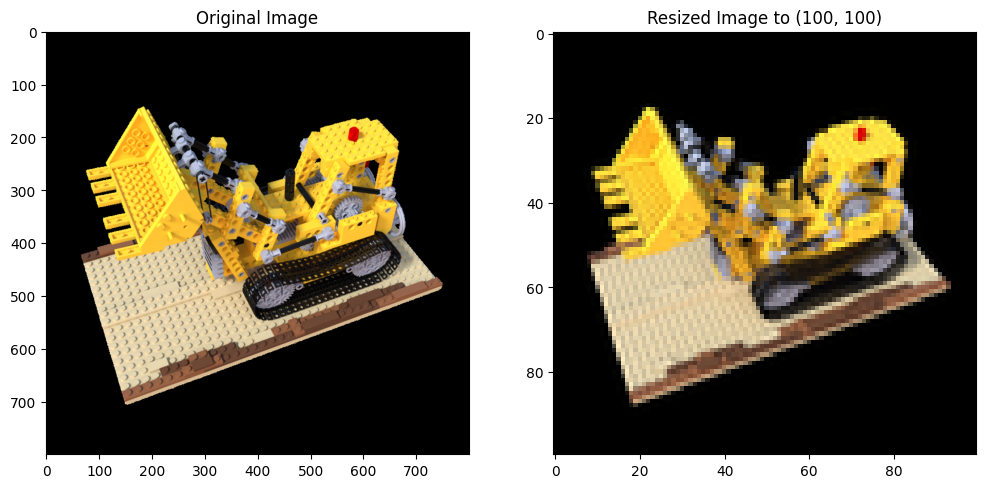

In [7]:
resized_train_images = resize_images(train_images, (100, 100))
val_images = resize_images(val_images, (100, 100))
test_images = resize_images(test_images, (100, 100))

display_images(train_images[0], resized_train_images[0])
train_images = resized_train_images
num_of_train_images, H, W, chanels = resized_train_images.shape


#### 1.3.2 Camera Parameters

In [8]:
# Open file with camera data - in read mode
with open('./data/nerf_synthetic/lego/transforms_train.json', 'r') as f:
    data = json.load(f)

# Given camera_angle_x (in radians) and image width W (in pixels)
camera_angle_x = data['camera_angle_x']

# Calculate the focal length
focal = W / (2 * math.tan(camera_angle_x / 2))

focal


138.88887889922103

In [9]:
# Open file with camera data - in read mode
with open('./data/nerf_synthetic/lego/transforms_train.json', 'r') as f:
    data = json.load(f)

# Extract the transform matrix for each frame
# Extract the transform matrices and convert them to tensors
poses = [] #poses represents the camera to world matrix
for frame in data['frames']:
    transform_matrix = np.array(frame['transform_matrix'], dtype=np.float32)
    poses.append(transform_matrix)

# Stack all the matrices into a single tensor
train_poses = np.stack(poses)

In [10]:
# Open file with camera data - in read mode
with open('./data/nerf_synthetic/lego/transforms_val.json', 'r') as f:
    data = json.load(f)

# Extract the transform matrix for each frame
# Extract the transform matrices and convert them to tensors
poses = [] #poses represents the camera to world matrix
for frame in data['frames']:
    transform_matrix = np.array(frame['transform_matrix'], dtype=np.float32)
    poses.append(transform_matrix)

# Stack all the matrices into a single tensor
val_poses = np.stack(poses)

In [12]:
# Open file with camera data - in read mode
with open('./data/nerf_synthetic/lego/transforms_test.json', 'r') as f:
    data = json.load(f)

# Extract the transform matrix for each frame
# Extract the transform matrices and convert them to tensors
poses = [] #poses represents the camera to world matrix
for frame in data['frames']:
    transform_matrix = np.array(frame['transform_matrix'], dtype=np.float32)
    poses.append(transform_matrix)

# Stack all the matrices into a single tensor
test_poses = np.stack(poses)
test_poses

array([[[-9.9999994e-01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00, -7.3411000e-01,  6.7903060e-01,  2.7372601e+00],
        [ 0.0000000e+00,  6.7903066e-01,  7.3410988e-01,  2.9592917e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-9.9802667e-01,  4.6095148e-02, -4.2636689e-02, -1.7187399e-01],
        [-6.2790513e-02, -7.3266143e-01,  6.7769074e-01,  2.7318587e+00],
        [-3.7252896e-09,  6.7903066e-01,  7.3410994e-01,  2.9592917e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-9.9211472e-01,  9.1993682e-02, -8.5120998e-02, -3.4313372e-01],
        [-1.2533323e-01, -7.2820497e-01,  6.7380208e-01,  2.7161829e+00],
        [ 0.0000000e+00,  6.7915744e-01,  7.3399270e-01,  2.9588192e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       ...,

       [[-9.8228788e-01, -1.3720389e-01,  1.2761407e-01,  5.1442873e-01],
        [ 1.8737729

## Training Code

In [ ]:
#Training Code
'''
Code Inspired by the Training Code in NerF
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')
'''
def train_nerf_model(
  model, optimizer, criterion, iters, train_data, device,
  num_freq_bands=8, batch_size=1024, near=2., far=6., N_samples=64):

  seed_everything(0)

  batch_ind = 0 #batch index
  psnrs, mses, num_iter = [], [], []
  t = time.time()
  num_chunks = 5
    
  def batchify(rays, num_chunks):
    ray_chunks = torch.chunk(rays, num_chunks, dim=1)
    for k in range(num_chunks):
      #model, num_freq_bands, rays, near, far, N_samples, rand=False):
      rgb_chunk, depth_chunk, acc_chunk = render_rays(model, num_freq_bands, ray_chunks[k].to(device), near, far, N_samples, rand=False)
      # Merge the results from each chunk back together
      if k != 0:
        rgb, depth, acc = torch.cat((rgb, rgb_chunk), dim=0), torch.cat((depth, depth_chunk), dim=0), torch.cat((acc, acc_chunk), dim=0)  
      else:
        rgb, depth, acc = rgb_chunk, depth_chunk, acc_chunk
    return rgb, depth, acc

  def define_rays():
    # Render the holdout view for logging
    # use global variables here
    rays = torch.tensor(get_rays(H, W, focal, poses[v,...])).reshape(2, -1, 3)
                    
    # Use the batchified function
    rgb, depth, acc =batchify(rays,num_chunks=5)
    rgb, depth, acc = rgb.reshape(100, 100, 3), depth.reshape(100, 100, 1), acc.reshape(100, 100, 1) 
    return rgb, depth, acc

  for i in range(iters):
    # iterate data
    batch = training_data[batch_ind: batch_ind + batch_size]
    batch_ind += batch_size
    rays = torch.moveaxis(torch.tensor(batch[:, :2]).to(device), 1, 0)
    target = torch.tensor(batch[:, 2]).to(device)
    if batch_ind > training_data.shape[0]:
      batch_ind = 0

    # Reset the gradients of the optimizer
    optimizer.zero_grad()
    # Forward pass through the model to obtain predictions
    rgb_map, depth_map, acc_map = render_rays(model, num_freq_bands, rays, near, far, N_samples, rand=True)
    # Compute the loss between the predictions and the training data
    loss = criterion(rgb_map, target)

    # Backward pass through the model to compute gradients
    loss.backward()

    # Update the model parameters using the optimizer
    optimizer.step()

    # Every 1000 iterations, compute and store the training and testing PSNRs,
    if i % 1000 == 0 or i == iters:
      model.eval()
      with torch.no_grad():
        psnr = []
        mse_list=[]
        # use global training poses here
        num_vals = poses.shape[0] if i == iters else 1
        for v in range(num_vals):
          rgb, depth, acc = define_rays()

          loss = criterion(rgb, torch.tensor(images[v,...], device=device))
          
          psnr.append(-10. * torch.log10(loss))
          
          mse_loss=criterion(rgb, torch.tensor(images[v, ...], device=device))
          mse_list.append(mse_loss.item())

          print(i, (time.time() - t), 'secs per 1000 iters', 'psnr:', psnr[-1])
          t = time.time()

          psnr = torch.mean(torch.tensor(psnr))
          psnrs.append(psnr)

          mse = torch.mean(torch.tensor(mse_list))
          mses.append(mse)

          num_iter.append(i)
          print(f"mse:{mse}, psnrs:{psnr}")

        model.train()

      #plot results
      plt.figure(figsize=(10,4))
      plt.imshow(rgb.cpu().numpy())
      #tensor rgb is in gpu, plt.imshow expects a numpy array, which resides in cpu main memory
      plt.title(f'Iteration: {i}')
      plt.subplot(122)
      plt.plot(num_iter, psnrs)
      plt.title('PSNR')
      plt.show() 

      plt.title(f'Iteration: {i}')
      plt.plot(num_iter, mses)
      plt.title('MSE')
      plt.show()
 
  # Return the training and testing results as a dictionary
  return {
    'psnrs': psnrs,
    'mses': mses,
    'num_iter': num_iter,
  }
